In [ ]:
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt

In [1]:
# First step : get the relevant dataset for all the orders (RFM_DF)
orders   = pd.read_csv('olist_orders_dataset.csv')
customers= pd.read_csv('olist_customers_dataset.csv')
items    = pd.read_csv('olist_order_items_dataset.csv')

customers = customers.take([0,1], axis=1)
RFM_DF = orders.take([0,1,2,3], axis=1)
RFM_DF = pd.merge(RFM_DF, customers, how='left', on='customer_id')
RFM_DF = RFM_DF.loc[~RFM_DF['order_status'].isin(['unavailable','canceled']),:]

items = items.groupby('order_id').agg({'price':'sum', 'freight_value':'sum'})
items['price'] = items['price'] + items['freight_value']
items = items.drop('freight_value', axis=1)

RFM_DF = pd.merge(RFM_DF, items, how='left', on='order_id')
RFM_DF = RFM_DF.loc[~RFM_DF['price'].isna(), :]
RFM_DF['order_purchase_timestamp'] = RFM_DF['order_purchase_timestamp']\
.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
RFM_DF = RFM_DF.sort_values('order_purchase_timestamp')
RFM_DF = RFM_DF.reset_index(drop=True)

In [2]:
def get_rfm_dataset(DF, date_fin):
    
    '''This function returns the RFM data for all the orders sent before the
    date 'date_fin', from the dataframe (will be RFM_DF in fact)'''
    
    DF = DF.loc[DF['order_purchase_timestamp'] <= date_fin, :]
    DF = DF.groupby('customer_unique_id').agg({'order_id': 'last',
                                               'customer_id': 'count',
                                               'order_status': 'last',
                                               'order_purchase_timestamp': \
                                               ['first', 'last'],
                                               'price': 'sum'})
    DF = DF.reset_index()
    DF.columns = ['customer_unique_id', 'last_order_id', 'nb_of_orders',
                  'last_order_status', 'first_purchase_date',
                  'last_purchase_date', 'orders_total_amount']
    DF['recency'] = date_fin - DF['last_purchase_date']
    DF['recency'] = DF['recency'].apply(lambda x: x.days)
    DF['frequency'] = date_fin - DF['first_purchase_date']
    DF['frequency'] = DF['frequency'].apply(lambda x: x.days)
    DF.loc[DF['frequency'] == 0.0, 'frequency'] = 1  # avoid div by 0
    DF['frequency'] = (DF['nb_of_orders'] - 1)*365.25 / DF['frequency']
    DF.loc[DF['frequency'] == 0.0, 'frequency'] = 0.5
    DF.loc[DF['frequency'] > 10, 'frequency'] = 8 + np.log(DF['frequency']) 
    # above : allows to keep frequency a reasonnable value (8 + ln(10) ~ 10.3)
    DF['M'] = np.log(DF['orders_total_amount'] + 1)
    DF['R'] = np.log(DF['recency'] + 1)
    DF = DF.take([8,9,10], axis=1)
    return DF

F0 = get_rfm_dataset(RFM_DF, datetime.strptime('2017-12-31 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
F0.head()  # F0 is the reference period data

,frequency,M,R
0,0.5,4.468434,5.693732
1,0.5,3.798182,4.394449
2,0.5,5.287711,3.871201
3,0.5,5.018074,5.713733
4,0.5,3.401197,5.117994


In [3]:
SScaler0 = StandardScaler()
SScaler0.fit(F0)
km0_data = SScaler0.transform(F0)

KM0 = KMeans(n_clusters=5, n_init=10)
KM0.fit(km0_data)

KMeans(n_clusters=5, n_init=10)

In [5]:
# F1 has two weeks data more than F0
F1 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-01-14 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler1 = StandardScaler()
SScaler1.fit(F1)
km1_data = SScaler1.transform(F1)

KM1 = KMeans(n_clusters=5, n_init=10)
KM1.fit(km1_data)

KMeans(n_clusters=5, n_init=10)

In [6]:
# Comparison between the clusters that the original k-means would have defined
# on the refreshed data, and those defined by the new k-means on same data :
km01_data = SScaler0.transform(F1)
KM01 = KM0.predict(km01_data)
ARI1 = adjusted_rand_score(KM01, KM1.labels_)

In [7]:
ARI1

0.37509651049761344

In [10]:
# This is a very low value ! Let's see with F2 :
F2 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-01-28 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler2 = StandardScaler()
SScaler2.fit(F2)
km2_data = SScaler2.transform(F2)

KM2 = KMeans(n_clusters=5, n_init=10)
KM2.fit(km2_data)

KMeans(n_clusters=5, n_init=10)

In [11]:
km02_data = SScaler0.transform(F2)
KM02 = KM0.predict(km02_data)
ARI2 = adjusted_rand_score(KM02, KM2.labels_)
ARI2

0.7435514353295803

In [12]:
F3 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-02-11 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler3 = StandardScaler()
SScaler3.fit(F3)
km3_data = SScaler3.transform(F3)

KM3 = KMeans(n_clusters=5, n_init=10)
KM3.fit(km3_data)

KMeans(n_clusters=5, n_init=10)

In [13]:
km03_data = SScaler0.transform(F3)
KM03 = KM0.predict(km03_data)
ARI3 = adjusted_rand_score(KM03, KM3.labels_)
ARI3

0.5165127215989875

In [14]:
F4 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-02-25 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler4 = StandardScaler()
SScaler4.fit(F4)
km4_data = SScaler4.transform(F4)

KM4 = KMeans(n_clusters=5, n_init=10)
KM4.fit(km4_data)

KMeans(n_clusters=5, n_init=10)

In [15]:
km04_data = SScaler0.transform(F4)
KM04 = KM0.predict(km04_data)
ARI4 = adjusted_rand_score(KM04, KM4.labels_)
ARI4

0.823116659330722

Nous voyons qu'en utilisant un k-means avec k = 5, qui n'est pas la valeur ayant le meilleur score de Calinski-Harabasz, mais qui me paraissait un peu plus interessante pour la segmentation, nous n'obtenons pas de résultat probant. Il faut donc travailler avec 4 classes :

In [3]:
SScaler0 = StandardScaler()
SScaler0.fit(F0)
km0_data = SScaler0.transform(F0)

KM0 = KMeans(n_clusters=4, n_init=10)
KM0.fit(km0_data)

KMeans(n_clusters=4, n_init=10)

In [4]:
F1 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-01-14 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler1 = StandardScaler()
SScaler1.fit(F1)
km1_data = SScaler1.transform(F1)

KM1 = KMeans(n_clusters=4, n_init=10)
KM1.fit(km1_data)

KMeans(n_clusters=4, n_init=10)

In [5]:
km01_data = SScaler0.transform(F1)
KM01 = KM0.predict(km01_data)
ARI1 = adjusted_rand_score(KM01, KM1.labels_)
ARI1

0.8472845808461578

In [6]:
# Effectively the value is a lot better !
F2 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-01-28 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler2 = StandardScaler()
SScaler2.fit(F2)
km2_data = SScaler2.transform(F2)

KM2 = KMeans(n_clusters=4, n_init=10)
KM2.fit(km2_data)

KMeans(n_clusters=4, n_init=10)

In [7]:
km02_data = SScaler0.transform(F2)
KM02 = KM0.predict(km02_data)
ARI2 = adjusted_rand_score(KM02, KM2.labels_)
ARI2

0.7451861113162318

In [8]:
# A so quick decrease !? Let's see with F3 :
F3 = get_rfm_dataset(RFM_DF, datetime.strptime('2018-02-11 23:59:59',\
                                               '%Y-%m-%d %H:%M:%S'))
SScaler3 = StandardScaler()
SScaler3.fit(F3)
km3_data = SScaler3.transform(F3)

KM3 = KMeans(n_clusters=4, n_init=10)
KM3.fit(km3_data)

KMeans(n_clusters=4, n_init=10)

In [9]:
km03_data = SScaler0.transform(F3)
KM03 = KM0.predict(km03_data)
ARI3 = adjusted_rand_score(KM03, KM3.labels_)
ARI3

0.8460682018795087

In [11]:
# So, an unexpected decrease with F2 but fine result with F3.
# To continue easily, let's define a function which will repeat the process :

def get_ARI_after_period(DF, nper, SScaler0, KM0):
    '''This fonction will return the ARI resulting from the comparison
    between the clusters given for the updated data from the reference
    model and the updated model; nper is the number of two weeks periods
    added in the updated data'''
    end_date = datetime.strptime('2017-12-31 23:59:59','%Y-%m-%d %H:%M:%S')
    end_date = end_date + timedelta(days=14*nper)
    Fn = get_rfm_dataset(DF, end_date)
    SScaler = StandardScaler()
    SScaler.fit(Fn)
    km_data = SScaler.transform(Fn)
    KM = KMeans(n_clusters=4, n_init=10)
    KM.fit(km_data)
    km0n_data = SScaler0.transform(Fn)
    KM0n = KM0.predict(km0n_data)
    return adjusted_rand_score(KM0n, KM.labels_)

for n in [4,5,6,7,8]:
    ARI = get_ARI_after_period(RFM_DF, n, SScaler0, KM0)
    print('For nper = ' + str(n) + ', ARI = ' + str(ARI))


For nper = 4, ARI = 0.8750565490763913
For nper = 5, ARI = 0.8389701985676846
For nper = 6, ARI = 0.8595994740175152
For nper = 7, ARI = 0.8877142177265126
For nper = 8, ARI = 0.8607054185100719


In [12]:
for n in range(9,16):
    ARI = get_ARI_after_period(RFM_DF, n, SScaler0, KM0)
    print('For nper = ' + str(n) + ', ARI = ' + str(ARI))


For nper = 9, ARI = 0.8508671273250937
For nper = 10, ARI = 0.844939151854078
For nper = 11, ARI = 0.79683940666122
For nper = 12, ARI = 0.8027311430983108
For nper = 13, ARI = 0.7962686171777776
For nper = 14, ARI = 0.7414651475472798
For nper = 15, ARI = 0.8004523375753252


In [13]:
for n in range(16,22):
    ARI = get_ARI_after_period(RFM_DF, n, SScaler0, KM0)
    print('For nper = ' + str(n) + ', ARI = ' + str(ARI))


For nper = 16, ARI = 0.8322207459694635
For nper = 17, ARI = 0.7866444268328036
For nper = 18, ARI = 0.6491919571476785
For nper = 19, ARI = 0.5474434942668915
For nper = 20, ARI = 0.4830421277576616
For nper = 21, ARI = 0.4391293284106256


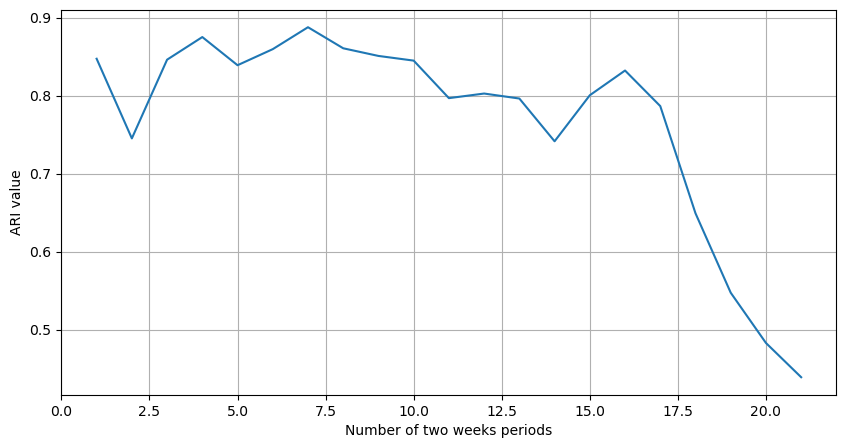

In [16]:
# graphicaly :
ARI_list = [0.8473,0.7452,0.8461,0.8751,0.839,0.8596,0.8877,0.8607,0.8509,0.8449,
            0.7968,0.8027,0.7963,0.7415,0.8005,0.8322,0.7866,0.6492,0.5474,0.483,
            0.4391]

plt.figure(figsize=(10,5))
plt.plot(range(1,22),ARI_list)
plt.xlabel('Number of two weeks periods')
plt.ylabel('ARI value')
plt.grid()
plt.show()

Nous observons qu'à partir de 17 périodes de deux semaines (14 jours) la valeur de l'ARI entre les classes initiales et les classes contenant les données arrivées entre temps est durablement inférieure à 0,8. Il faut donc reconstituer la classification après ces 238 jours (34 semaines) pour être sûr d'avoir une représentation réaliste de la clientèle par les classes du k-means.
<br>En arrondissant on peut fixer la période de renouvelement de la classification à 8 mois maximum, toutefois on serait plus serein de le faire tous les six mois puisqu'on voit qu'on peut passer sous les 0,8 dés 22 semaines, sans beaucoup remonter au delà.